In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from Bio import SeqIO
from scipy.special import xlogy
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro, ttest_ind, mannwhitneyu


mito_gb = next(SeqIO.parse('../data/human_mitochondrion.gb', "genbank"))

In [2]:
# courtesy of Liu, K., Xie, N., & Wang, Y. (2023). Quantifying mitochondrial heteroplasmy diversity: A computational approach. Mol Ecol Resour. doi:10.1111/1755-0998.13874.
def d_chao(A, lev, q): 
    tot = np.sum(A)
    if tot == 0:
        return 0 
    
    eA = A / tot

    cA = np.sum(A, axis=0)
    N = A.shape[0]

    ecA = cA / tot
  
    if lev == 'alpha':
        if q != 1:
            Da = (1 / N) * np.sum(eA**q)**(1 / (1 - q))
            D_value = Da
        else:
            Da = np.exp(-np.sum(xlogy(eA, eA)) - np.log(N))
            D_value = Da
    
    if lev == 'beta':
        D_value = d_chao(A, lev='gamma', q=q) / d_chao(A, lev='alpha', q=q)
    
    if lev == 'gamma':
        if q != 1:
            Dg = np.sum(ecA**q)**(1 / (1 - q))
            D_value = Dg
        else:
            Dg = np.exp(-np.sum(xlogy(ecA, ecA)))
            D_value = Dg
    
    return D_value

def Cq(A, beta, q, N):
    if q != 1:
        cq = (((1 / beta) ** (q - 1)) - ((1 / N) ** (q - 1))) / (1 - (1 / N) ** (q - 1))
    else:
        cq = 1 - (np.log(1 / beta)/np.log(1 / N))
    return cq



def Uq(A, beta, q, N):
    if q != 1:
        uq = (((1 / beta) ** (1 - q)) - ((1 / N) ** (1 - q))) / (1 - (1 / N) ** (1 - q))
    else:
        uq = 1 - (np.log(1 / beta)/np.log(1 / N))    
    return uq

def Sq(A, beta, q, N):
    sq = ((1 / beta) - (1 / N)) / (1 - 1 / N)
    return sq

def Vq(A, beta, q, N):
    vq = 1 - ((beta - 1) / (N - 1))
    return vq

In [3]:
def calc_het_lvl(het_df):
    het_df = het_df[het_df['Total_Depth'] >= 1000].reset_index().drop(columns=['index'])

    het_lvls = pd.DataFrame(columns=['Sample', 'het_lvl'])
    for i in het_df.index:
        sample = het_df.iloc[i,0]
        ref_allele = het_df.iloc[i,2]
        position = het_df.iloc[i, 1]
        ref_fraction = het_df[f"Fraction_{ref_allele}"][i]

        minority_fraction = 1 - ref_fraction
        het_lvls.loc[i,'Sample'] = sample
        het_lvls.loc[i,'het_lvl'] = minority_fraction
        het_lvls.loc[i,'Position'] = position

    het_lvls = het_lvls[(het_lvls['het_lvl'] >= 0.05) & (het_lvls['het_lvl'] <= 0.95)]

    return het_lvls

In [4]:
het_df = pd.read_csv('../data/heteroplasmy_ALL.csv')
het_df = het_df[het_df['Total_Depth'] >= 1000].reset_index(drop=True)

# will leave only heteroplasmies 
het_df = calc_het_lvl(het_df)

het_count = {}
for sample, data in het_df.groupby('Sample'):
    affected_type = []
    for feat in mito_gb.features:
        filter = ('gene', 'misc_feature', 'source')
        if feat.type not in filter:
            for position in data['Position']:
                if feat.location.__contains__(int(position)):
                    affected_type.append(feat.type)
    het_count[sample] = dict(Counter(affected_type))
het_count = pd.DataFrame.from_dict(het_count, orient="index").fillna(0).astype(int)
het_count = het_count.reset_index().rename(columns={"index": "ID"})
het_count

,ID,D-loop,tRNA,CDS,rRNA
0,5,1,1,1,0
1,6,2,1,2,0
2,7,1,1,1,0
3,11,4,1,2,0
4,13,3,1,1,0
...,...,...,...,...,...
77,162,2,1,1,0
78,166,1,1,2,0
79,173,1,1,1,0
80,181,3,1,1,0


In [5]:
# beta-div split
het_count = het_count.set_index('ID')
anamnesis = pd.read_csv('../data/anamnesis.csv', index_col=0)
print(Counter(anamnesis.iloc[:,0]))
anamnesis = anamnesis.iloc[:,0].map({"МС": "sick", "ГС":"healthy", "УЗД":"healty"})
het_count['status'] = anamnesis.reindex(het_count.index)
sick_het_count = het_count[het_count['status'] == 'sick'].drop(columns=['status']).reset_index().rename(columns={"index": "ID"})
healthy_het_count = het_count[het_count['status'] == 'healthy'].drop(columns=['status']).reset_index().rename(columns={"index": "ID"})

# reset all het for alpha
het_count = het_count.drop(columns=['status']).reset_index().rename(columns={"index": "ID"})

Counter({'МС': 78, 'УЗД': 72, 'ГС': 38})


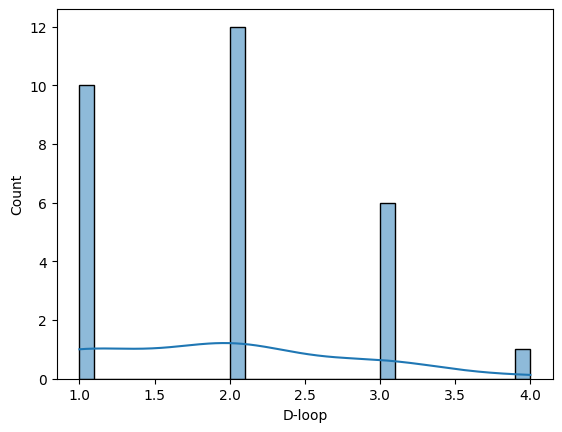

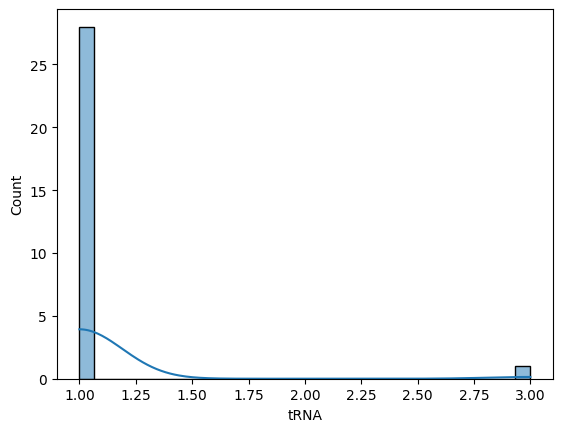

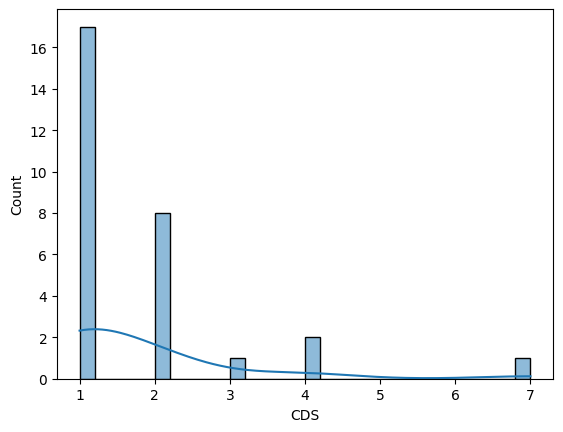

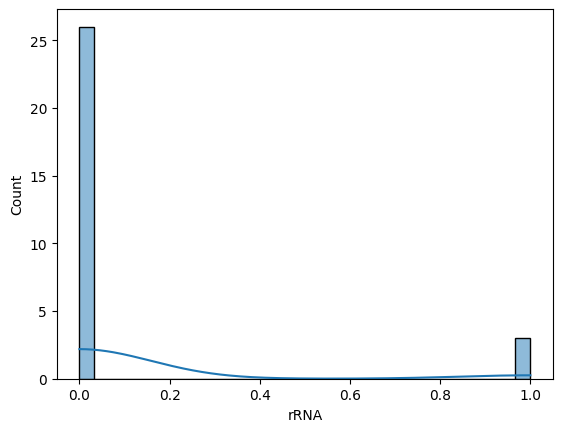

In [6]:
for data in sick_het_count.drop(columns=['ID']).columns:
    sns.histplot(data=sick_het_count, x=data, kde=True, bins=30)
    plt.show()

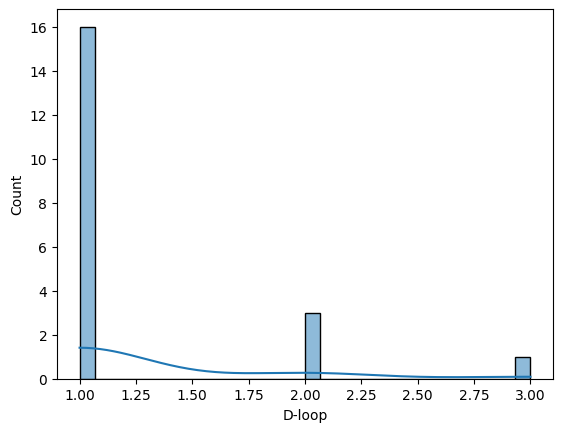

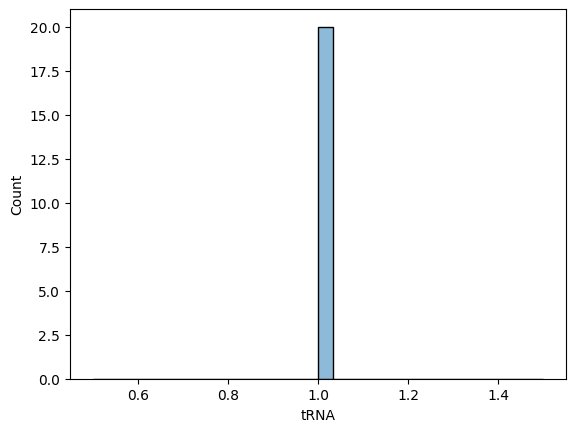

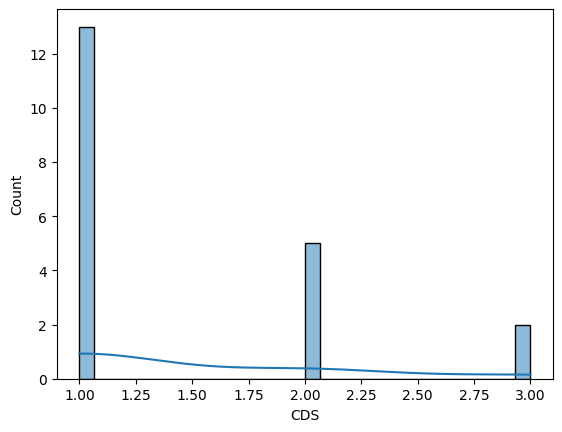

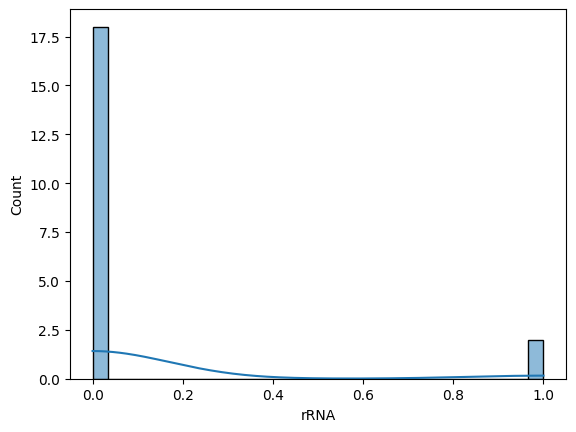

In [7]:
for data in healthy_het_count.drop(columns=['ID']).columns:
    sns.histplot(data=healthy_het_count, x=data, kde=True, bins=30)
    plt.show()

In [8]:
regions = ['D-loop', 'tRNA', 'CDS', 'rRNA']

results = []
for region in regions:
    group_false = healthy_het_count[region]
    group_true = sick_het_count[region]
    
    # Normality check
    p_norm_false = shapiro(group_false).pvalue
    p_norm_true = shapiro(group_true).pvalue
    
    # Choose test
    if p_norm_false > 0.05 and p_norm_true > 0.05:
        stat, pval = ttest_ind(group_false, group_true, equal_var=False)
        test_type = 't-test'
    else:
        stat, pval = mannwhitneyu(group_false, group_true, alternative='two-sided')
        test_type = 'Mann-Whitney'
    
    results.append((region, test_type, pval))

df_stats = pd.DataFrame(results, columns=['gene', 'Test', 'p-value'])

print(df_stats)

     gene          Test   p-value
0  D-loop  Mann-Whitney  0.002158
1    tRNA  Mann-Whitney  0.430152
2     CDS  Mann-Whitney  0.589485
3    rRNA  Mann-Whitney  0.984526


/mnt/data/Documents/misc_code/obesityxmutations/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
# get mean helthy and mean sick samples. is that correct?
sick_het_count['ID'] = 'sick'
sick_het_count = sick_het_count.groupby('ID').mean().reset_index().rename(columns={"index": "ID"})

healthy_het_count['ID'] = 'healthy'
healthy_het_count = healthy_het_count.groupby('ID').mean().reset_index().rename(columns={"index": "ID"})

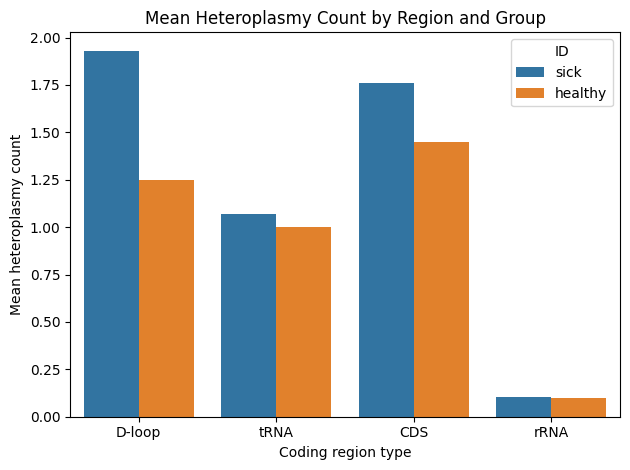

In [27]:
compare_het_count = pd.concat([sick_het_count, healthy_het_count])
df_melted = compare_het_count.reset_index().melt(id_vars='ID', 
                                  value_vars=['D-loop', 'tRNA', 'CDS', 'rRNA'],
                                  var_name='Region', 
                                  value_name='Heteroplasmy_Count')

sns.barplot(data=df_melted, x='Region', y='Heteroplasmy_Count', hue='ID')
plt.title('Mean Heteroplasmy Count by Region and Group')
plt.xlabel('Coding region type')
plt.ylabel('Mean heteroplasmy count')
plt.tight_layout()
plt.show()

In [28]:
compare_het_count.columns

Index(['ID', 'D-loop', 'tRNA', 'CDS', 'rRNA'], dtype='object')

In [60]:
Alpha = []
grouped_data = het_count.groupby('ID')
for group_name, group_data in grouped_data:
    group_array = np.nan_to_num(group_data.iloc[:, 1:].astype(float).values)
    q0 = d_chao(group_array, "alpha", 0)
    q1 = d_chao(group_array, "alpha", 1)
    q2 = d_chao(group_array, "alpha", 2)
    Alpha.append([group_name] + [q0] + [q1] + [q2])
Alpha = np.array(Alpha)

colnames = ["ID", "q=0", "q=1", "q=2"]
Alpha = pd.DataFrame(Alpha, columns=colnames)
Alpha.to_csv('../data/alpha-div.tsv', sep='\t', index=False)
Alpha

,ID,q=0,q=1,q=2
0,5.0,4.0,3.000000,3.000000
1,6.0,4.0,2.871746,2.777778
2,7.0,4.0,3.000000,3.000000
3,11.0,4.0,2.600490,2.333333
4,13.0,4.0,2.586409,2.272727
...,...,...,...,...
77,162.0,4.0,2.828427,2.666667
78,166.0,4.0,2.828427,2.666667
79,168.0,4.0,1.889882,1.800000
80,173.0,4.0,3.000000,3.000000


In [61]:
df1 = sick_het_count
df2 = healthy_het_count

Res = pd.DataFrame(columns=["ID-sick", "ID-healthy", "beta.D", "cq"])
visited_pairs = set()
grouped_data1 = df1.groupby('ID')
grouped_data2 = df2.groupby('ID')
for group_name1, group_data1 in grouped_data1:
    for group_name2, group_data2 in grouped_data2:
        #if group_name1 == group_name2:
            #continue
        if (group_name1, group_name2) in visited_pairs or (group_name2, group_name1) in visited_pairs:
            continue
        visited_pairs.add((group_name1, group_name2))            
        group_array1 = np.nan_to_num(group_data1.iloc[:, 1:].astype(float).values)
        group_array2 = np.nan_to_num(group_data2.iloc[:, 1:].astype(float).values)
        sda = np.vstack((group_array1, group_array2))
        beta = d_chao(sda, "beta", 1)
        cqn = Cq(sda, beta, 1, sda.shape[0]) 
        #uqn = Uq(sda, beta, 2, sda.shape[0]) 
        #sqn = Sq(sda, beta, 2, sda.shape[0]) 
        #vqn = Vq(sda, beta, 2, sda.shape[0]) 
        res = pd.DataFrame([[group_name1, group_name2, beta, cqn]], columns=["ID-sick", "ID-healthy", "beta.D", "cq"])
        Res = pd.concat([Res, res], ignore_index=True)
Res.to_csv('../data/beta-div.tsv', sep='\t', index=False)
Res

/tmp/ipykernel_122906/2132408102.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Res = pd.concat([Res, res], ignore_index=True)


,ID-sick,ID-healthy,beta.D,cq
0,sick,healthy,1.010388,0.985091


In [62]:
df1 = sick_het_count
df2 = healthy_het_count

Res = pd.DataFrame(columns=["ID-sick", "ID-healthy", "gamma.D"])
visited_pairs = set()
grouped_data1 = df1.groupby('ID')
grouped_data2 = df2.groupby('ID')
for group_name1, group_data1 in grouped_data1:
    for group_name2, group_data2 in grouped_data2:
        #if group_name1 == group_name2:
            #continue
        if (group_name1, group_name2) in visited_pairs or (group_name2, group_name1) in visited_pairs:
            continue
        visited_pairs.add((group_name1, group_name2))            
        group_array1 = np.nan_to_num(group_data1.iloc[:, 1:].astype(float).values)
        group_array2 = np.nan_to_num(group_data2.iloc[:, 1:].astype(float).values)
        sda = np.vstack((group_array1, group_array2))
        gamma = d_chao(sda, "gamma", 1)
        res = pd.DataFrame([[group_name1, group_name2, gamma]], columns=["ID-sick", "ID-healthy", "gamma.D"])
        Res = pd.concat([Res, res], ignore_index=True)
Res.to_csv('../data/gamma-div.tsv', sep='\t', index=False)
Res

/tmp/ipykernel_122906/3586288486.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Res = pd.concat([Res, res], ignore_index=True)


,ID-sick,ID-healthy,gamma.D
0,sick,healthy,3.208722


In [63]:
anamnesis = pd.read_csv('../data/anamnesis.csv', index_col=0)
anamnesis = anamnesis.iloc[:,0].map({"МС":1, "ГС":0, "УЗД":0})
Alpha = Alpha.set_index('ID')
Alpha['disease'] = anamnesis.reindex(Alpha.index)

In [64]:
Alpha

,q=0,q=1,q=2,disease
ID,,,,
5.0,4.0,3.000000,3.000000,1
6.0,4.0,2.871746,2.777778,1
7.0,4.0,3.000000,3.000000,1
11.0,4.0,2.600490,2.333333,1
13.0,4.0,2.586409,2.272727,1
...,...,...,...,...
162.0,4.0,2.828427,2.666667,0
166.0,4.0,2.828427,2.666667,0
168.0,4.0,1.889882,1.800000,0


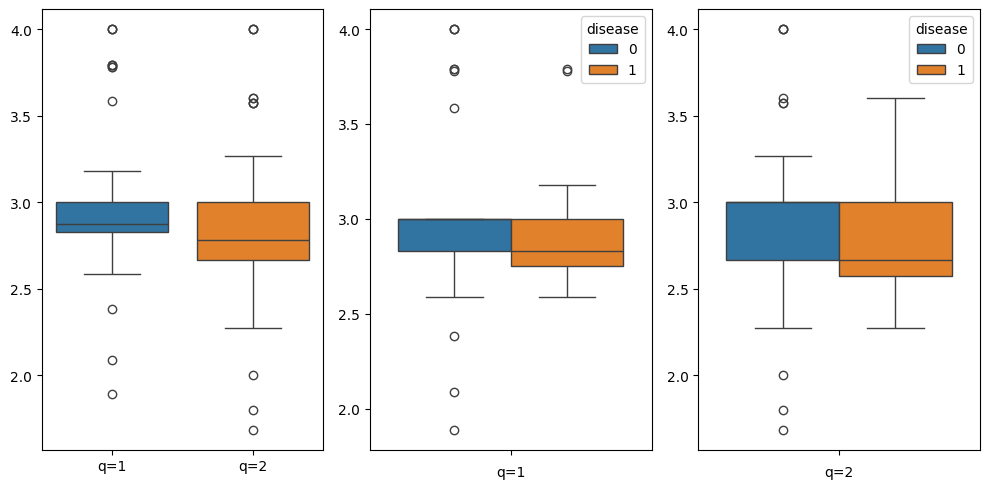

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(data=Alpha[['q=1','q=2']], ax=axes[0])
sns.boxplot(data=Alpha, y='q=1', hue='disease', ax=axes[1])
sns.boxplot(data=Alpha, y='q=2', hue='disease', ax=axes[2])
axes[1].set_xlabel('q=1')
axes[1].set_ylabel('')
axes[2].set_xlabel('q=2')
axes[2].set_ylabel('')
plt.tight_layout()
plt.show()